## Modified Slim

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde
import os
from utils.gs_solovev_sol import GS_Linear

######################
# ITER shape #
######################
eps_deviation = 0.2
kappa_deviation = 0.2
delta_deviation = 0.2
eps0 = (0.32 - eps_deviation, 0.32 + eps_deviation)
kappa0 = (1.7 - kappa_deviation, 1.7 + kappa_deviation)
delta0 = (0.33 - delta_deviation, 0.33 + delta_deviation)
Amax = 0.2
num_param = 5
Arange = np.linspace(-Amax, Amax, num_param)
eps = np.linspace(eps0[0], eps0[1], num_param)
kappa = np.linspace(kappa0[0], kappa0[1], num_param)
delta = np.linspace(delta0[0], delta0[1], num_param)

def gen_traindata(num):
    N = num
    center = np.array(
        [[0.0, 0.0, 0.0, 
          eps0[1] - eps0[0], 
          kappa0[1] - kappa0[0],
          delta0[1] - delta0[0]]]
    )
    tau = np.linspace(0, 2 * np.pi, N)
    R_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    Z_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    A_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    eps_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    kappa_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    delta_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    for i in range(num_param):
        for j in range(num_param):
            for k in range(num_param):
                for kk in range(num_param):
                    R_ellipse[:, i, j, k, kk] = 1 + eps[j] * np.cos(tau + np.arcsin(delta[kk]) * np.sin(tau))
                    Z_ellipse[:, i, j, k, kk] = eps[j] * kappa[k] * np.sin(tau)
                    A_ellipse[:, i, j, k, kk] = Arange[i]
                    eps_ellipse[:, i, j, k, kk] = eps[j]
                    kappa_ellipse[:, i, j, k, kk] = kappa[k]
                    delta_ellipse[:, i, j, k, kk] = delta[kk]
    
    x_ellipse = np.transpose(
        np.asarray([
            R_ellipse, Z_ellipse, A_ellipse, 
            eps_ellipse, kappa_ellipse, delta_ellipse]), 
                             [1, 2, 3, 4, 5, 0])
    x_ellipse = x_ellipse.reshape(N * num_param ** 4, 6)
    uvals = np.zeros(len(x_ellipse)).reshape(len(x_ellipse), 1)
    return x_ellipse, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    A = x[:, 2:3]
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)


spatial_domain = dde.geometry.HyperEllipticalToroid(
    eps0, kappa0, delta0, Amax=Amax
) 

x, u = gen_traindata(1000)

n_test = 100
x_test,u_test = gen_traindata(n_test)
x_domain = spatial_domain.random_points(n_test)
x_test = np.concatenate((x_test, x_domain))
u_test = np.concatenate((u_test, np.zeros((n_test, 1))))

bc135 = dde.PointSetBC(x,u)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    num_domain=1028,
    num_boundary=0,
    num_test=n_test,
    train_distribution="LHS"
)


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



Text(0.5, 0, '$u(r,z=0)$')

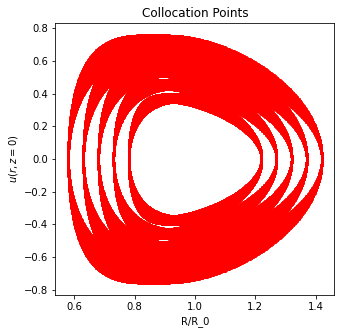

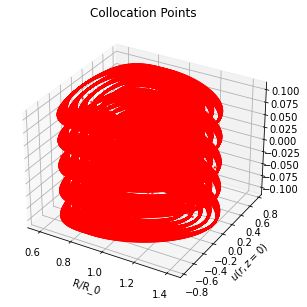

In [2]:
# Plot collocation points for visual check
# %matplotlib

fig,ax=plt.subplots(1, figsize=(5, 5))
ax.scatter(data.train_x_bc[:, 0], data.train_x_bc[:, 1], s=2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

fig =plt.figure(2, figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    data.train_x[:, 0], 
    data.train_x[:, 1], 
    data.train_x[:, 2], 
    s=2, 
    color='r'
)
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

## Train Model

In [ ]:
DATE = "10122022"
CONFIG = "ITER"
LR = 2e-1
DEPTH = 4
BREADTH = 40
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"
PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"

# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([6] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate * (i + 1)),
      loss_weights=[1, 1]
  )
  loss_history, train_state = model.train(
      epochs=100, 
      display_every=10,
  )
  dde.saveplot(
      loss_history, 
      train_state, 
      issave=True, 
      isplot=True,
      output_dir=PATH
  )

Compiling model...
Building feed-forward neural network...
'build' took 0.197157 s



/Users/alankaptanoglu/deepxde_copy/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'compile' took 4.851893 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.10e+00, 9.46e-04]    [1.09e+00, 9.46e-04]    []  


#### After BFGS

In [ ]:
options = {
    "disp": None,
    "maxcor": 50,
    "ftol": np.finfo(float).eps,
    "gtol": 1e-8,
    "eps": 1e-8,
    "maxfun": 15000,
    "maxiter": 1000,
    "iprint": -1,
    "maxls": 50,
}

# Compile, train and save model
model.compile(
    "L-BFGS-B", 
    loss_weights=[1, 100],
    # options=options,
)

loss_history, train_state = model.train(
    epochs=1,
    display_every=10, 
)
dde.saveplot(
    loss_history, 
    train_state, 
    issave=True, 
    isplot=True,
    output_dir=PATH
)


In [ ]:
# Evaluation
from utils.utils import *
ITER = GS_Linear(eps=eps[0], kappa=kappa[0], delta=delta[0])
ITER.get_BCs(A=Arange[0])
ITER.solve_coefficients()
full, yfull, psi_pred_full, psi_true_full, error = evaluate(
    ITER, model,
)
nx = psi_true_full.shape[0]
ny = psi_true_full.shape[0]
psi_pred_parametrized = np.zeros(
    (nx, ny, num_param, num_param, num_param, num_param)
)
psi_true_parametrized = np.zeros(
    (nx, ny, num_param, num_param, num_param, num_param)
)
x = np.zeros((nx, ny, num_param, num_param, num_param, num_param))
y = np.zeros((nx, ny, num_param, num_param, num_param, num_param))
for i in range(num_param):
    for j in range(num_param):
        for k in range(num_param):
            for kk in range(num_param):
                ITER = GS_Linear(eps=eps[j], kappa=kappa[k], delta=delta[kk])
                ITER.get_BCs(A=Arange[i])
                ITER.solve_coefficients()
                xfull, yfull, psi_pred_full, psi_true_full, error = evaluate(
                    ITER, model,
                )
                x[:, :, i, j, k, kk] = xfull
                y[:, :, i, j, k, kk] = yfull
                psi_pred_parametrized[:, :, i, j, k, kk] = psi_pred_full
                psi_true_parametrized[:, :, i, j, k, kk] = psi_true_full

In [ ]:
# Plotting Setup
import matplotlib.colors as colors
average_errors = np.zeros((num_param, num_param, num_param, num_param))
max_errors = np.zeros((num_param, num_param, num_param, num_param))

for i in range(0, num_param, 2):
    plt.figure(i + 1, figsize=(20, 40))
    q = 1
    for j in range(0, num_param, 2):
        for k in range(0, num_param, 2):
            for kk in range(0, num_param, 2):
                average_errors[i, j, k, kk] = np.mean(abs(
                        psi_true_parametrized[:, :, i, j, k, kk] - psi_pred_parametrized[:, :, i, j, k, kk]
                    ) / np.max(
                            abs(psi_true_parametrized[:, :, i, j, k, kk])
                        )
                  )
                max_errors[i, j, k, kk] = np.max(abs(
                        psi_true_parametrized[:, :, i, j, k, kk] - psi_pred_parametrized[:, :, i, j, k, kk]
                    ) / np.max(
                            abs(psi_true_parametrized[:, :, i, j, k, kk])
                        )
                  )
#                 zoom = ((1 + eps[j])-(1 - eps[j]))*0.05
#                 innerPoint = 1 - eps[j] - zoom
#                 outerPoint = 1 + eps[j] + zoom
#                 lowPoint   = -kappa[k] * eps[j] - zoom
#                 highPoint  = kappa[k] * eps[j] + zoom
                innerPoint = 0.5
                outerPoint = 1.5
                lowPoint = -1.5
                highPoint = 1.5
                plt.subplot(int(np.ceil(num_param / 2)) ** 3, 3, q)
                levels = np.linspace(
                    min(psi_true_parametrized[:, :, i, j, k, kk].reshape(-1)), 0, 10
                )    
                cp = plt.contour(
                    x[:, :, i, j, k, kk], y[:, :, i, j, k, kk], 
                    psi_pred_parametrized[:, :, i, j, k, kk],
                    levels=levels
                )
                plt.grid(True)
                plt.axis(
                    xmin=innerPoint,
                    xmax=outerPoint,
                    ymin=lowPoint, 
                    ymax=highPoint
                )
                plt.subplot(int(np.ceil(num_param / 2)) ** 3, 3, q + 1)
                cp = plt.contour(
                    x[:, :, i, j, k, kk], 
                    y[:, :, i, j, k, kk], 
                    psi_true_parametrized[:, :, i, j, k, kk],
                    levels=levels
                )
                plt.grid(True)
                plt.axis(
                    xmin=innerPoint,
                    xmax=outerPoint,
                    ymin=lowPoint, 
                    ymax=highPoint
                )
                plt.subplot(int(np.ceil(num_param / 2)) ** 3, 3, q + 2)
                errors = abs(psi_true_parametrized[:, :, i, j, k, kk] - psi_pred_parametrized[:, :, i, j, k, kk]) / np.max(
                        abs(psi_true_parametrized[:, :, i, j, k, kk]))
                cp = plt.contourf(
                    x[:, :, i, j, k, kk], 
                    y[:, :, i, j, k, kk], 
                    errors,
                    norm=colors.LogNorm(vmin=errors.min(), 
                                        vmax=errors.max()),
                    #levels=levels
                )
                plt.grid(True)
                plt.axis(
                    xmin=innerPoint,
                    xmax=outerPoint,
                    ymin=lowPoint, 
                    ymax=highPoint
                )
                plt.colorbar()
                q = q + 3

In [ ]:
import time 

nx = 30
ny = nx
zoom = 0.2
inner_point = (1 - 1.1*ITER.eps*(1+zoom))
outer_point = (1 + 1.1*ITER.eps*(1+zoom))
high_point  = (1.1*ITER.kappa * ITER.eps*(1+zoom) )
low_point   = (-1.1*ITER.kappa * ITER.eps*(1+zoom) )
x, y, A = np.meshgrid(
    np.linspace(inner_point, outer_point, nx),
    np.linspace(low_point, high_point, ny),
    np.linspace(-Amax, Amax, num_param),
    indexing='ij'
)
ones = np.ones(nx * ny * num_param)

X = np.vstack((
    np.ravel(x), np.ravel(y), np.ravel(A),
    ITER.eps * ones, ITER.kappa * ones, ITER.delta * ones
)).T
print(X.shape)
t1 = time.time()
model.predict(X)
t2 = time.time()
print(t2 - t1)

In [ ]:
plt.scatter(np.ravel(average_errors) * 100, np.ravel(max_errors) * 100)
plt.grid(True)
plt.xlabel('Normalized average errors (%)')
plt.ylabel('Normalized maximum errors (%)')
plt.show()